# Modele uczenia maszynowego

Rozwój technologii i powszechna cyfryzacja przyczyniły się do powstania nowego zasobu, jakim są dane.
Dane te są generowane i przetwarzane zarówno w sposób ustrukturyzowany, jak i nieustrukturyzowany. 
Strukturyzacja danych doprowadziła do rozwoju wielu modeli, które dziś ogólnie określamy jako modele uczenia maszynowego (ang. _machine learning_, ML). 
Natomiast przetwarzanie danych nieustrukturyzowanych takich jak tekst, obrazy czy wideo, przyczyniło się do rozwoju uczenia głębokiego (ang. _deep learning_, DL). 
Oba te podejścia często określane zbiorczo jako sztuczna inteligencja (ang. _artificial inteligence_, AI), zostały stworzone głównie do rozpoznawania wzorców. 
Jednak coraz częściej wykorzystywane są również do modelowania i generowania nowych danych. 
Klasyczny model sztucznej inteligencji możemy wyrazić jako funkcję $f(X,\theta)$, która zależy zarówno od danych reprezentowanych przez ustrukturyzowaną macierz $X$, jak i od parametrów  $\theta$, których wartości zostają ustalone w procesie uczenia.

W uczeniu nadzorowanym posiadamy wartości zmiennej celu dla wygenerowanych danych treningowych. Dwa podstawowe modele nadzorowanego uczenia maszynowego możemy zrealizować jako proste sieci neuronowe.

Do wygenerowania kodów użyjemy biblioteki PyTorch

## Regresja liniowa

Wygenerujemy niezaszumione dane na podstawie wzoru $y = 2 x - 1$. 
Na podstawie zbioru danych postaramy się oszacować nieznane parametry czyli wyraz przy $x$ ($\alpha_1 = 2$) i wyraz wolny ($\alpha_0 = -1$).

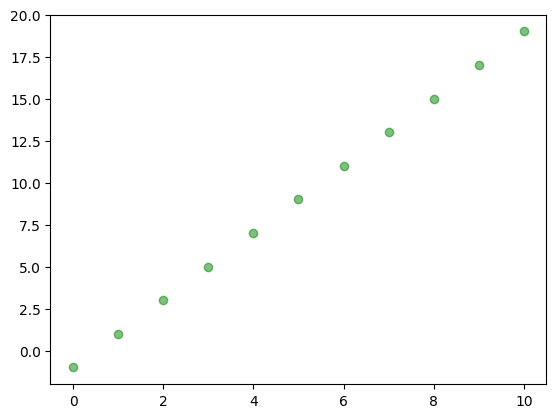

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# zbior danych
x = range(11)
y = [2*xi - 1 for xi in x]
plt.plot(x, y, 'go', label='True data', alpha=0.5)

Model regresji liniowej dla jednej zmiennej można zrealizować jako prostą jednowarstwową sieć neuronową. 
Cały proces można zrealizować za pomocą obiektu `torch.nn.Linear`

In [2]:
import torch

class LinearRegression(torch.nn.Module):

    def __init__(self, inputSize, outputSize):
        super(LinearRegression, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(inputSize, outputSize)
        ) 
        
    def forward(self, x):
        return self.layers(x)

Aby nasze dane mogłybyć przeliczane przez bibliotekę PyTorch musimy je przetworzyć na tensory - czyli obiekty z biblioteki PyTorch.

In [3]:
# dostosowanie do pytorch
x = np.array(x, dtype=np.float32)
y = np.array(y, dtype=np.float32)

X_train = torch.from_numpy(x).view(-1,1)
y_train = torch.from_numpy(y).view(-1,1)

Uwaga - ponieważ mamy jedną zmienną zawierającą 10 przypadków - potrzebujemy listy składającej się z 10 list jednoelementowych.

Mozna tez wykorzystac obiektowe programowanie. 

In [4]:
from torch.utils.data import Dataset, DataLoader

class LinearDataset(Dataset):
    def __init__(self, X_train, y_train):
        self.X_train = X_train # tensor typu torch
        self.y_train = y_train

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, idx):
        return self.X_train[idx], self.y_train[idx]

In [5]:
dataset = LinearDataset(X_train=X_train, y_train=y_train)

In [6]:
dataloader = DataLoader(dataset, shuffle=True, batch_size=2)

Możemy utworzyć model i wybrać optymalizator z funkcją kosztu. 

In [7]:
# obiekt liniowej regresji w wersji sieci nn
lr_model = LinearRegression(1,1)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(lr_model.parameters(), lr=0.01)

Możemy sprawdzić, że nasz model będzie dostrajał 2 parametry.

In [8]:
num_params = sum(p.numel() for p in lr_model.parameters() if p.requires_grad)
print(f"liczba trenowalnych parametrów: {num_params}")

liczba trenowalnych parametrów: 2


Parametry te w początkowej inicjalizacji mają następujące wartości:

In [9]:
for layer in lr_model.layers:
    if isinstance(layer, torch.nn.Linear):
        print(f"weight: {layer.state_dict()['weight']}")
        print(f"bias: {layer.state_dict()['bias']}")

weight: tensor([[-0.5483]])
bias: tensor([0.1822])


In [10]:
epochs = 100
# petla uczaca 
for epoch in range(epochs):
    lr_model.train() # etap trenowania 

    y_pred = lr_model(X_train)
    loss = criterion(y_pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 50 == 0:
        print(f'epoch: {epoch+1:03d}, loss = {loss.item():.2f}')
 
    lr_model.eval() # etap ewaluacji modelu

# po treningu jeszcze raz generujemy predykcje
lr_model.eval()
with torch.no_grad():
    predicted = lr_model(X_train)

epoch: 050, loss = 0.38
epoch: 100, loss = 0.22


Mozna tez wykorzystac obiekt `dataloader`

In [11]:
for epoch in range(50):
    for X_batch, y_batch in dataloader:
        preds = lr_model(X_batch)
        loss = criterion(preds, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, loss = {loss.item():.4f}")

Epoch 0, loss = 0.1676
Epoch 10, loss = 0.0017
Epoch 20, loss = 0.0771
Epoch 30, loss = 0.0643
Epoch 40, loss = 0.0054


Otrzymane parametry po uczeniu 

In [12]:
print(f"po procesie uczenia waga: {lr_model.layers[0].weight} oraz bias {lr_model.layers[0].bias}")

po procesie uczenia waga: Parameter containing:
tensor([[1.9822]], requires_grad=True) oraz bias Parameter containing:
tensor([-0.8443], requires_grad=True)


Dopasowanie modelu do danych można przedstawić na wykresie

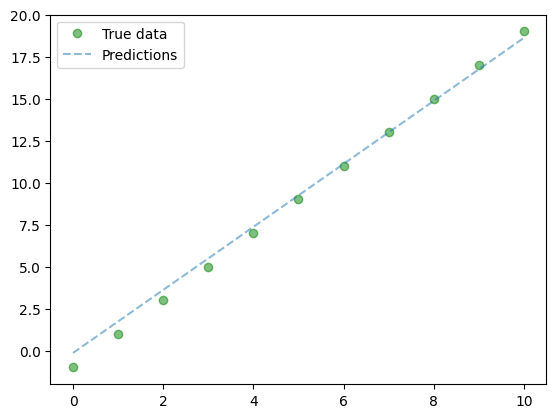

In [13]:
plt.clf()
plt.plot(X_train, y_train, 'go', label='True data', alpha=0.5)
plt.plot(X_train, predicted, '--', label='Predictions', alpha=0.5)
plt.legend(loc='best')
plt.show()